# Part 6.3 - Analysis Topic Model of WWI
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

**In this part, we will use the topic modeling result from part 6.1 to analyze the WWI time.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/wwi/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
0,0,0.001953,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
1,1,0.003492,day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...
2,2,0.002051,election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...
3,3,0.005437,oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...
4,4,0.006275,christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...


**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/wwi/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (340011, 6)


,id,region,year,topic,weight,keywords
0,3024904,unknown,1912-01,63,0.273152,cases case casks boxes ditto sale bags oil brandy sugar ale ...
1,3025071,unknown,1912-01,7,0.145646,police man arrested men murder found made shot night house c...
2,3026239,unknown,1912-02,28,0.143104,tin ill oil day lit zealand ton mil tie aro hat fur aid ail ...
3,3026663,unknown,1912-03,186,0.201166,man life great years world men time people work english huma...
4,3027602,unknown,1912-03,63,0.179133,cases case casks boxes ditto sale bags oil brandy sugar ale ...


**Average topic weight dataframe:**

In [6]:
path = r'../models/wwi/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (24000, 4)


,year,topic,weight,keywords
0,1912-01,0,0.001382,theatre tonight exhibition universal approved adults censor ...
1,1912-01,1,0.002731,day people procession mayor city crowd town large governor r...
2,1912-01,2,0.002041,election electors candidate candidates vote poll district vo...
3,1912-01,3,0.005644,oamaru aro thames dunedin north otago street waitaki john ze...
4,1912-01,4,0.006774,christchurch timaru ashburton street canterbury akaroa lytte...


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

,id,region,year,topic,weight,keywords
78127,16468964,West Coast,1919-07,172,0.936791,court accused witness police charged fined evidence case def...
62839,16185038,West Coast,1916-11,119,0.933710,public people men question great time good law country man p...
78067,16468013,West Coast,1919-07,172,0.932435,court accused witness police charged fined evidence case def...


In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

16468964

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 16468964
930090:16468964	TIDES.	TIDES.July 9—7.10 s.m; 7.40 p.m. July 10—8.7 a.m.; 8.35 p.m. July 11—9.2 a.m; 9.27 p.m. July 12—9.50 a.m; 10.15 p.m. July 13—10.37 a.m ; 10.59 p.m. July 14—11.19 a.m; 11.38 p.m. July 15—11.58 a.m; July 16—0.19 a.m; 0.40 p.m. July 17—1.2 a.m; 1.24 p.m. July 18—1.45 a.m; 2.7 p.m. July 19—2.30 a.m ; 2.55 p.m. July 20—3.20 a.m; 3.46 p.m. July 21—4.15 a.m; 4.43 p.m. July 22—5.20 a.m; 5.50 p.m. , July 23 — 6.28 a.m; 6.59 p.m. July 24—7.34 a.m; 8.0 p.m. July 25—8.32 a.m; 8.55 p.m. July 26—9.25 a.m; 9.50 p.m. July 27—10.14 a.m; 10.36 p.m. July 28—10.54 a.m; 11.14 p.m. July 29—11.33 a.m; 11.53 p.m. July 30 ; 0.13 p.m. ( July 31—0.35 a.m; 0.57 p.m.


## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the first 20 topics in topics list.**

In [11]:
df_plt = df_topics.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

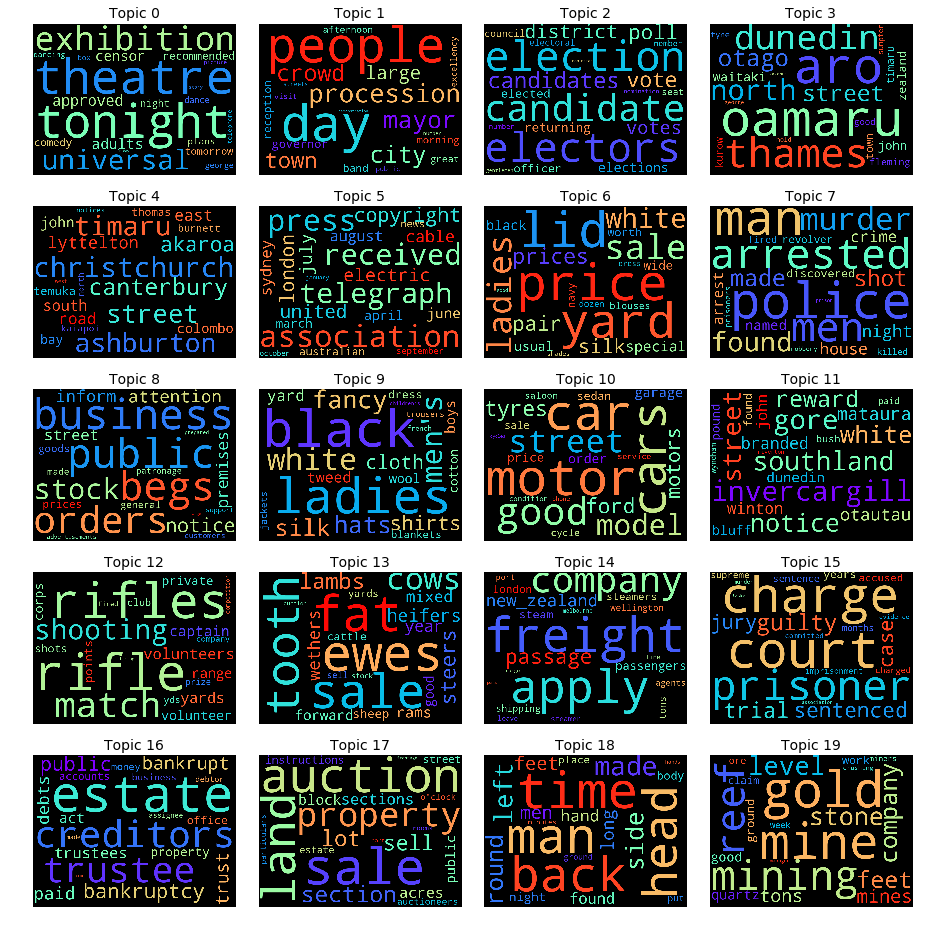

In [12]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

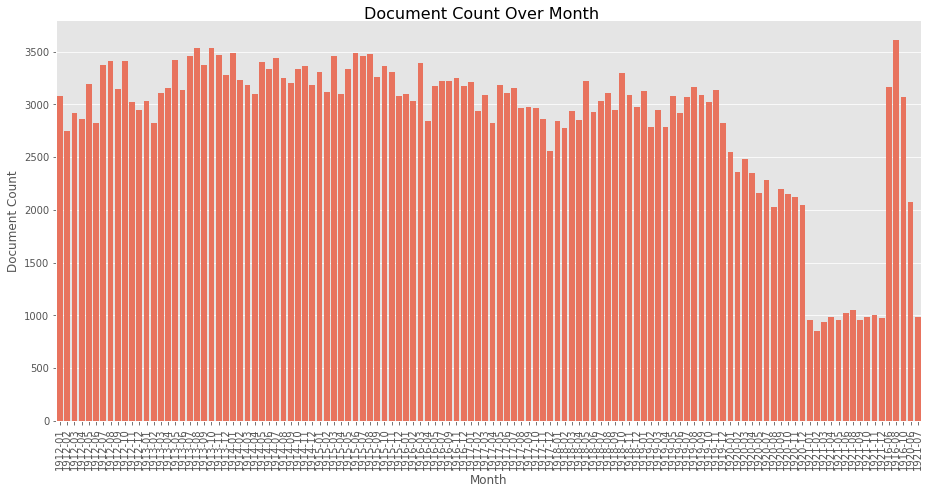

In [13]:
g = sns.catplot(x="year", color='tomato',
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Month", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Month', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

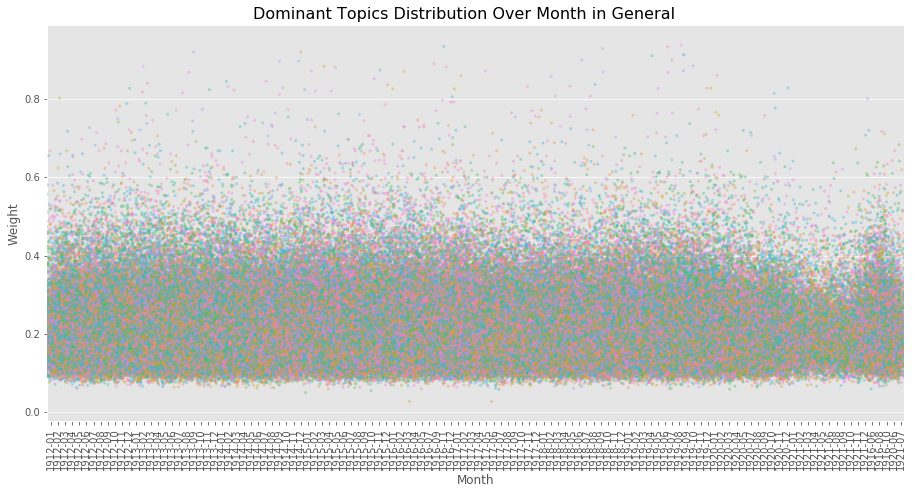

In [14]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.4, edgecolors='w',
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Month in General", fontsize=16)
g.set(xlabel='Month', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

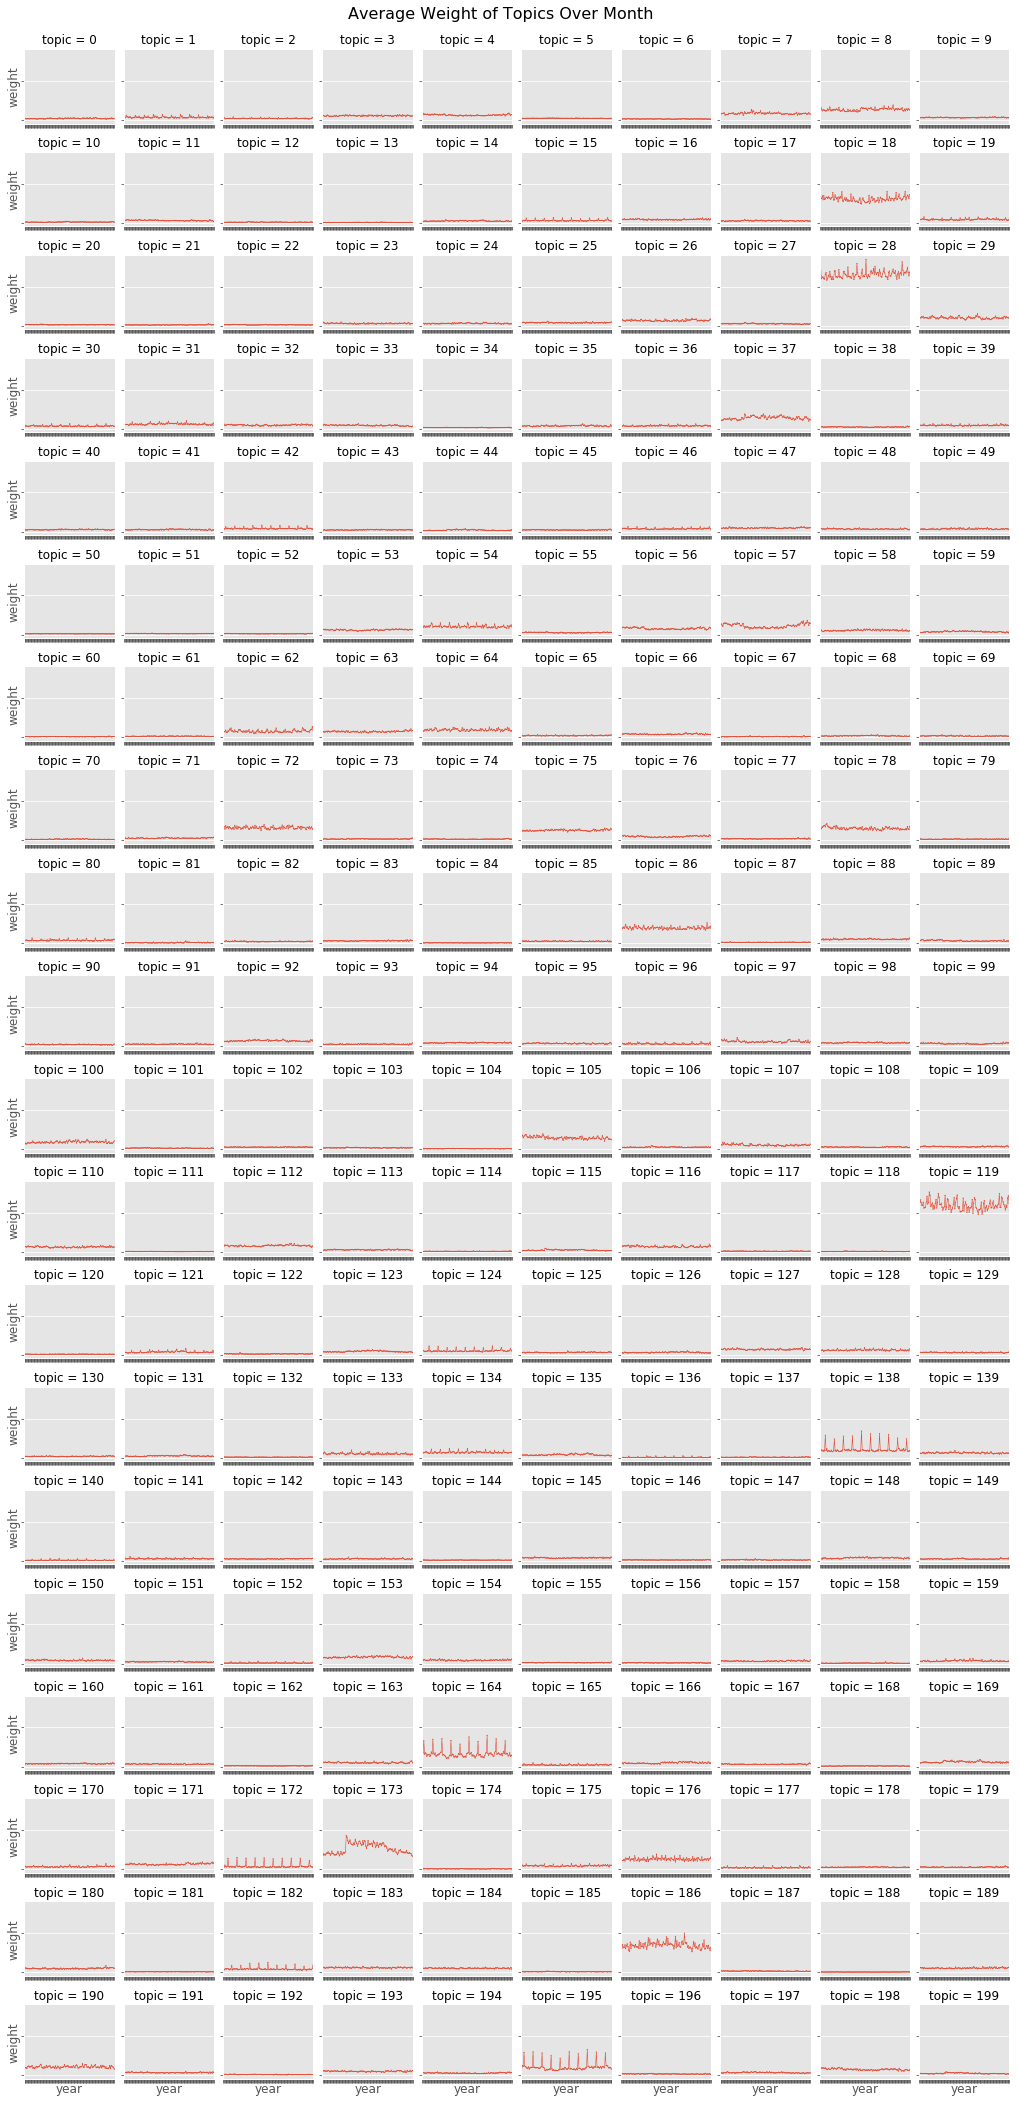

In [15]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Average Weight of Topics Over Month", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [16]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (9127, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
0,0.001953,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
1,0.003492,day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...
2,0.002051,election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...
3,0.005437,oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...
4,0.006275,christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...
5,0.002175,association press received telegraph copyright london united electric july cable sydney august june april march aust...
6,0.001344,price lid yard sale ladies white prices pair silk special black usual wide worth navy blouses dozen dress shades good
7,0.008426,police man arrested men murder found made shot night house crime arrest named discovered revolver fired killed priso...
8,0.013357,business public begs orders stock notice attention inform premises street prices goods general made patronage custom...


**Dominant topics distribution over month:**

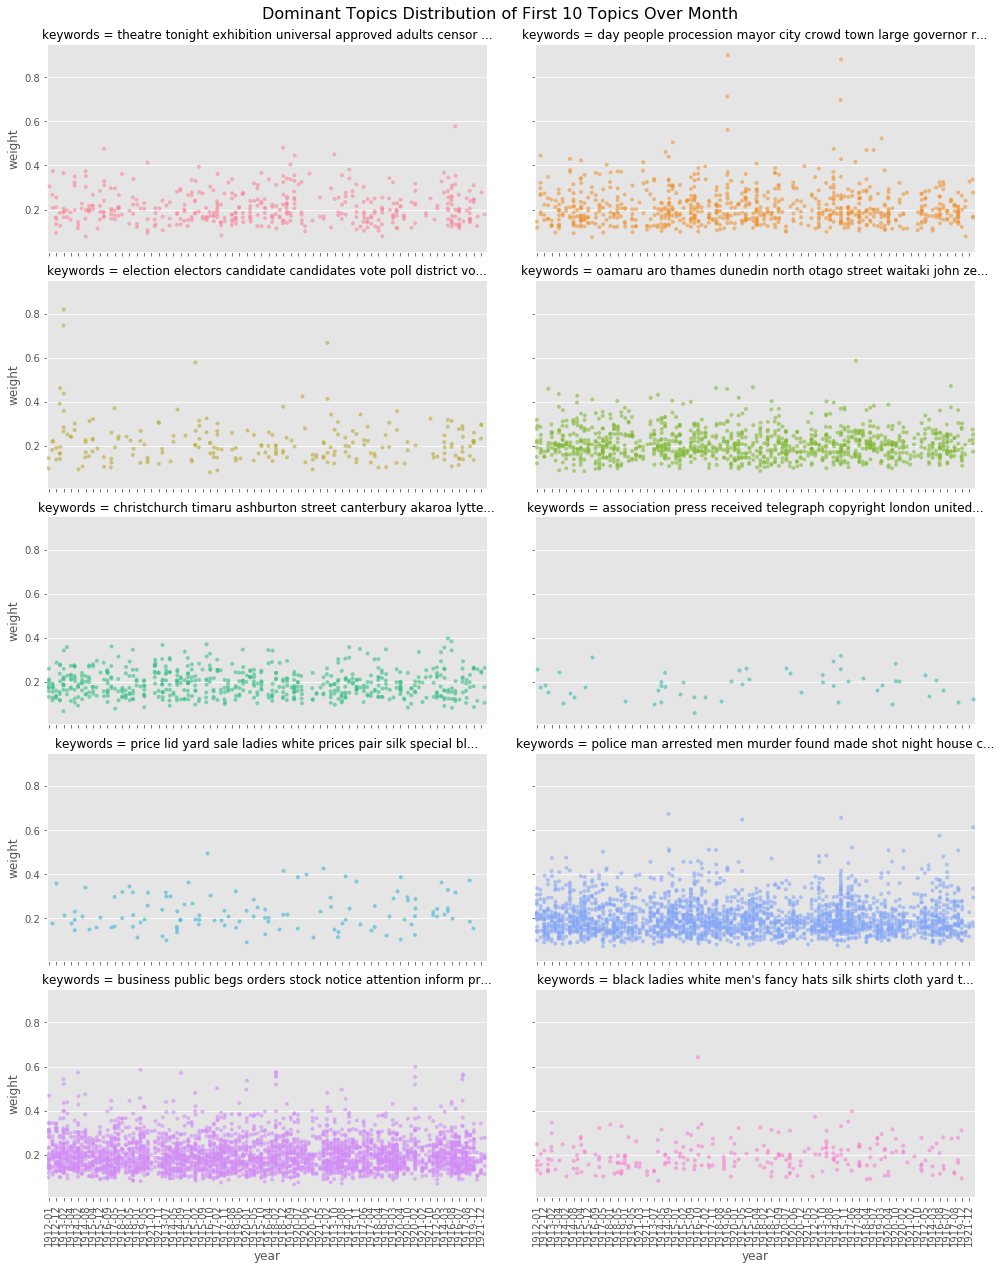

In [17]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

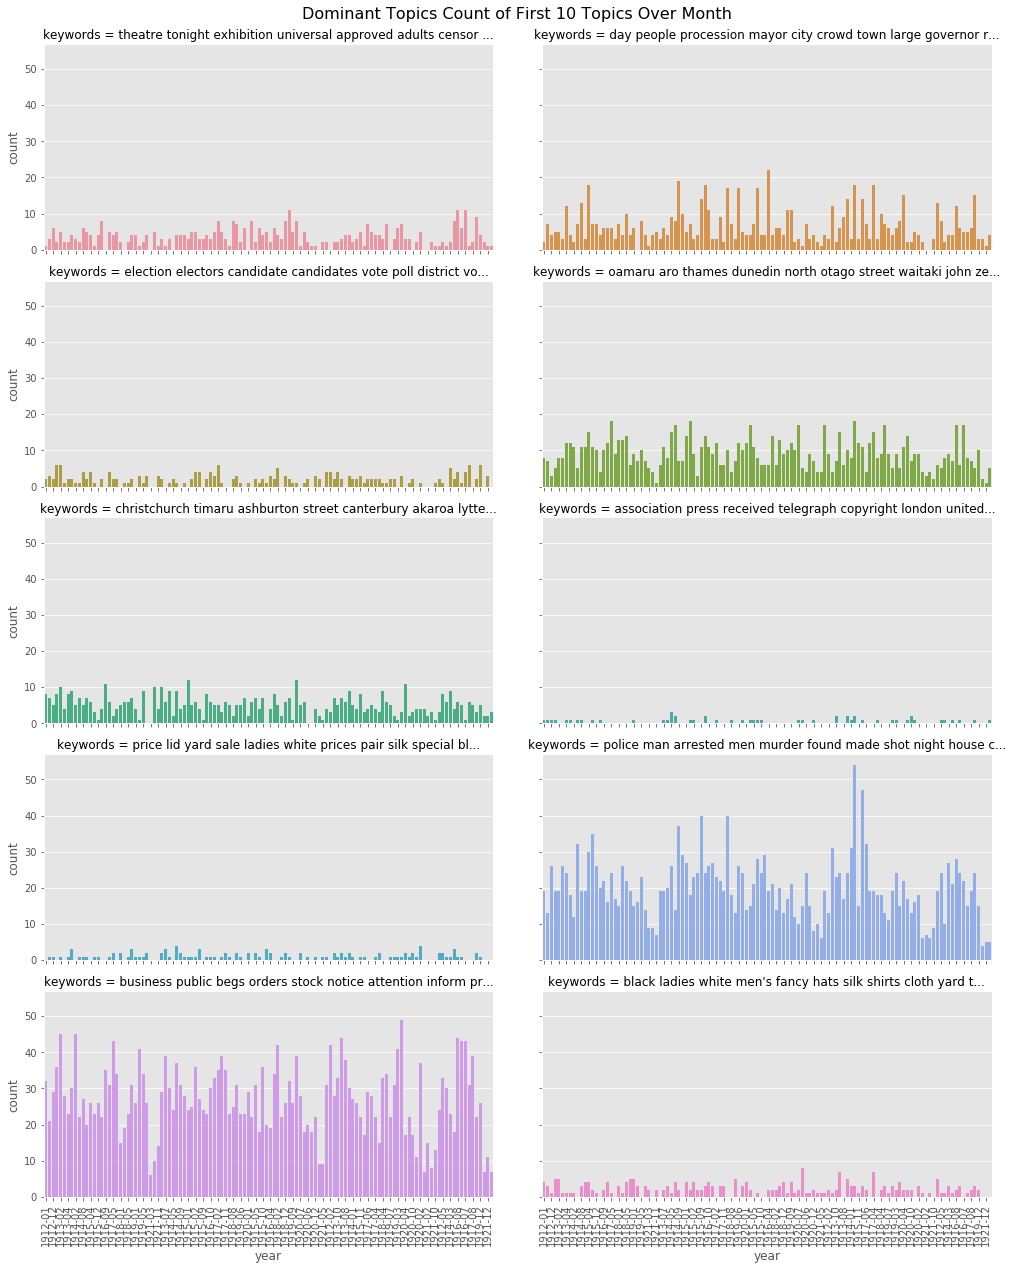

In [18]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

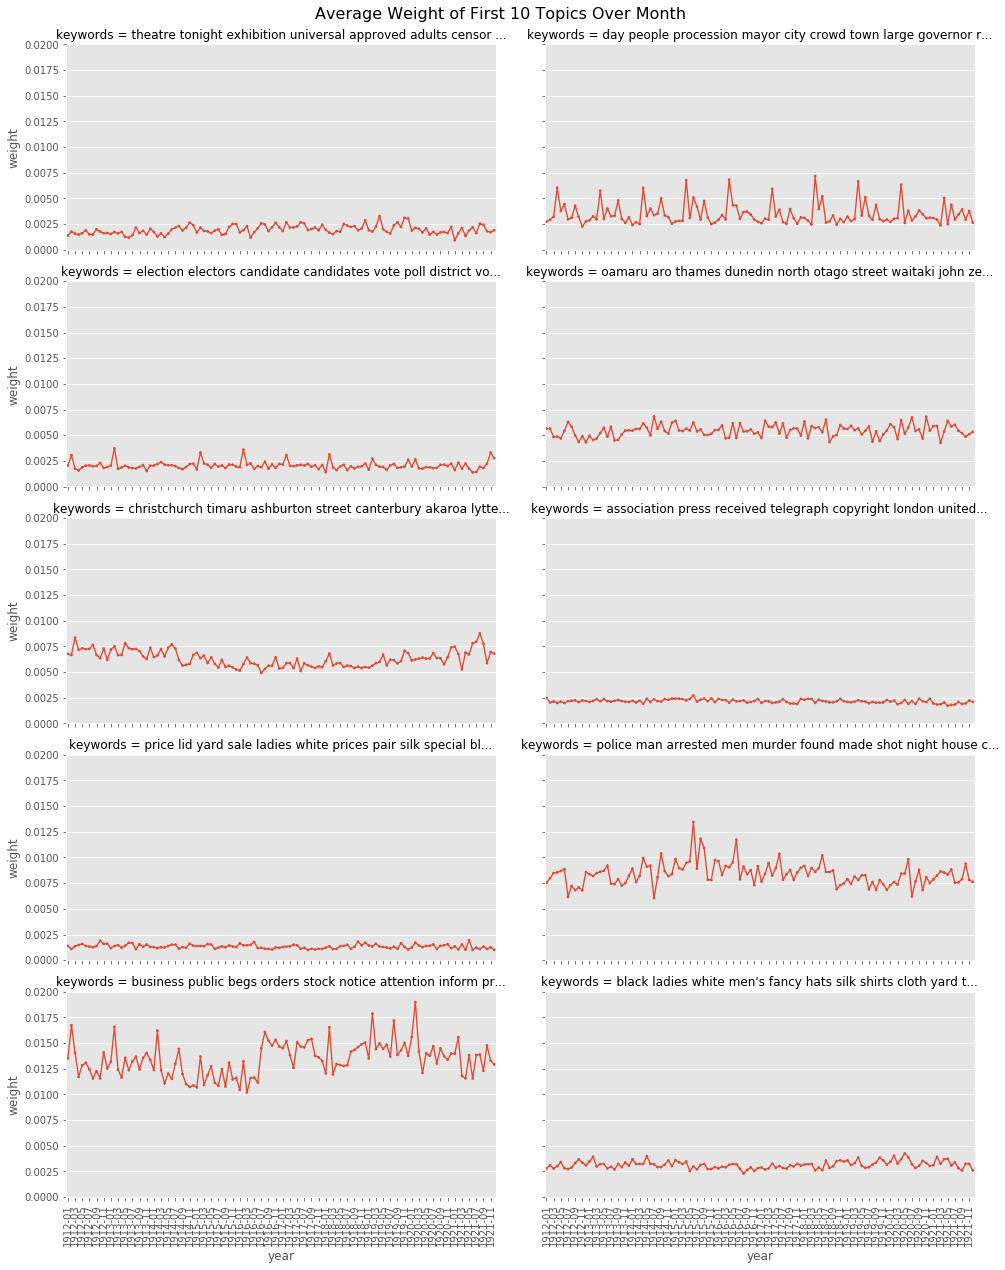

In [19]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [20]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [119, 28, 186, 173, 18, 164, 195, 138, 86, 72]
Shape of df_plt_dom: (187582, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
119,0.059602,public people men question great time good law country man present fact matter state opinion case system means gover...
28,0.065255,tin ill oil day lit zealand ton mil tie aro hat fur aid ail man end tins wai hut time
186,0.034862,man life great years world men time people work english human history good made fact long character nature modern mind
173,0.027360,love life heart day thy god world man eyes thou light long night earth great sweet thee death men home
18,0.030352,time man back head made left side round feet men long hand found night body place put ground minutes hands
164,0.016419,letter sir editor made public matter statement time paper fact question times opinion case give published correspond...
195,0.010369,hotel proprietor accommodation public spirits wines good travellers rooms brands attention visitors house stabling f...
138,0.011016,wheat oats flour potatoes market ton prices barley produce bran bushel good prime sacks butter chaff feed grain mill...
86,0.019540,time good present made great work fact large year number doubt place make years long past position matter success co...


**Dominant topics distribution over Month:**

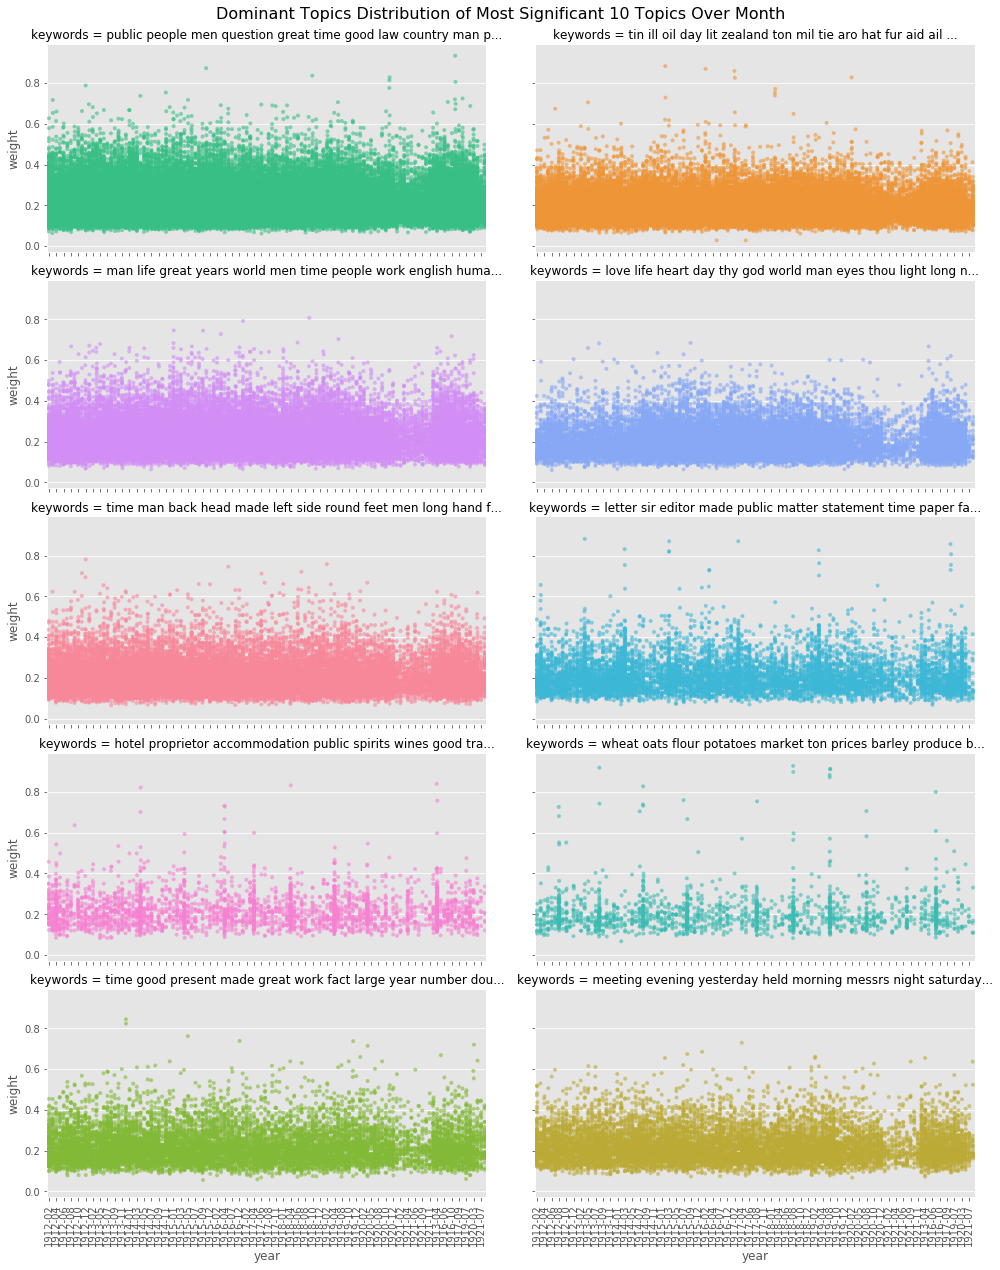

In [21]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

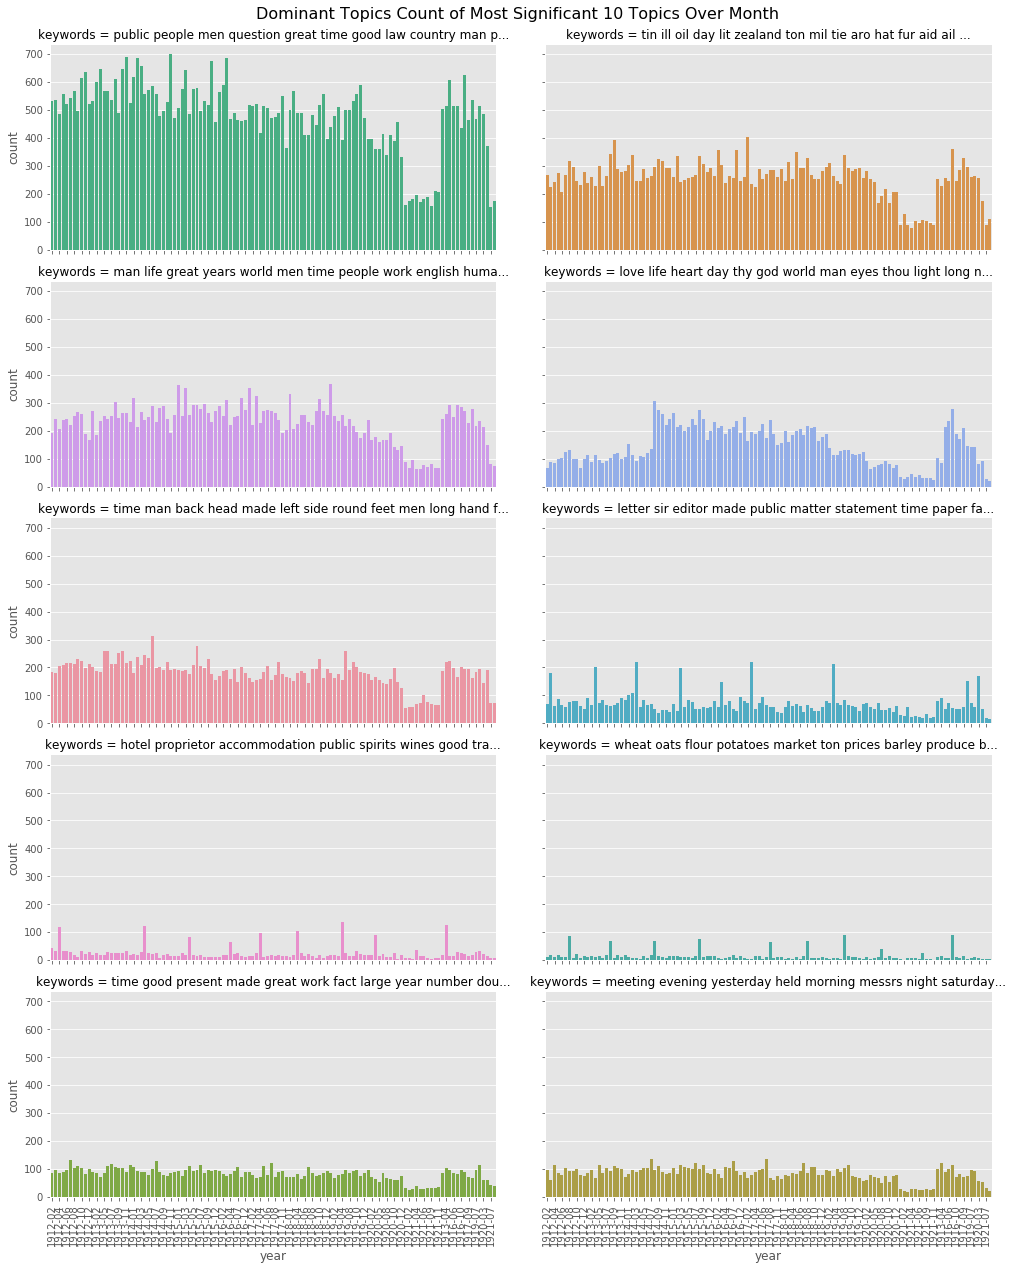

In [22]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

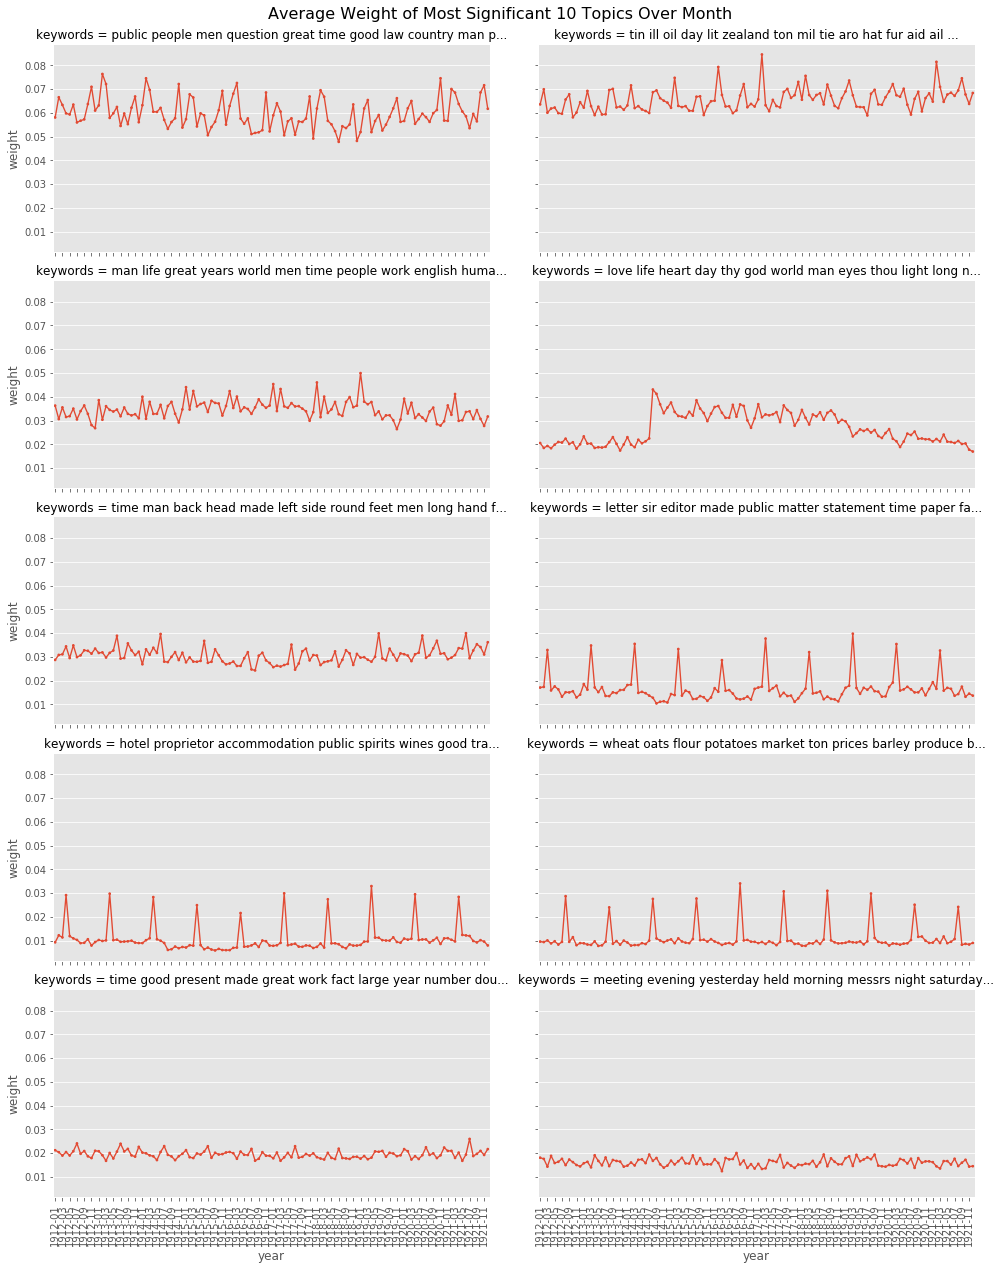

In [23]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

**By compare the topic weight in topic list, we can find out which topics are the most different in WWI. Here we are interested in both trend (the more or less popular topics) in WWI.**

In [24]:
path = r'../models/wwi/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare and contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [52, 188, 5, 34, 111, 136, 50, 192, 162, 67]
Shape of df_plt_dom: (698, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
52,0.001045,mails mail close office notices auckland letters wellington united_kingdom chief late europe post london due fee con...
188,0.000470,auckland wellington left due london lyttelton october september august november sydney december january march sailed...
5,0.002175,association press received telegraph copyright london united electric july cable sydney august june april march aust...
34,0.001470,wellington arrived morning nelson sailed tons auckland to-morrow to-day port leaves yesterday coast westport passeng...
111,0.000613,sellers buyers stock bank new_zealand sales national auckland exchange waihi cent pref insurance share ord wellingto...
136,0.000659,time won sec started min lengths length handicap mile half ssec furlongs meeting ran day easily weather results soys...
50,0.000997,wellington auckland dunedin christchurch canterbury new_zealand otago association north wanganui napier nelson press...
192,0.000975,moon quarter weather wind breeze water calm light high sun bar sets cape sky heads clouds barometer morning full to-...
162,0.000939,weather rain winds heavy hours strong moderate south wind forecast north to-day east coast gale yesterday barometer ...


**Dominant topics distribution over month:**

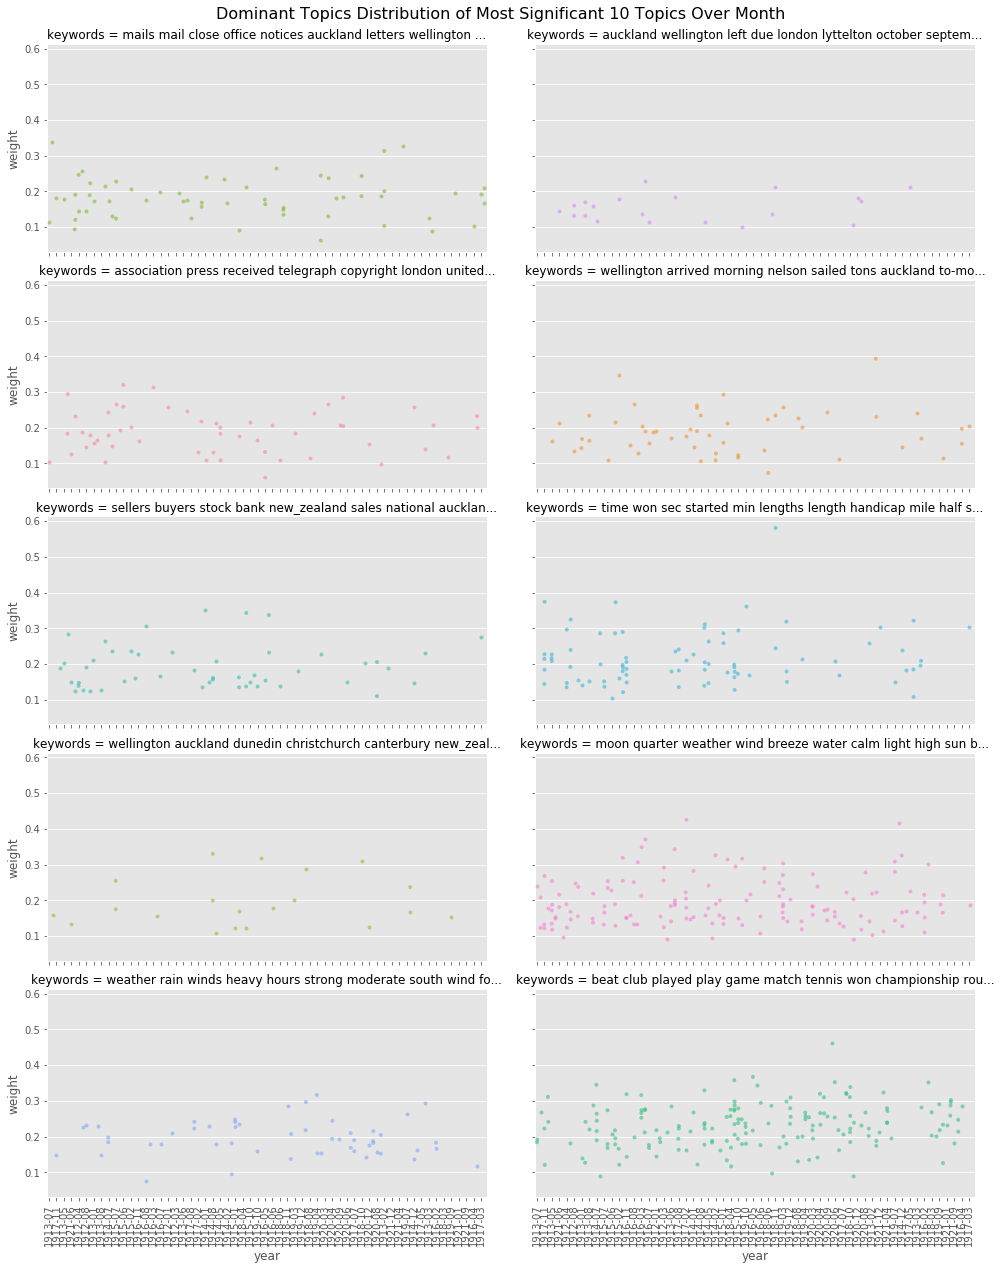

In [25]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

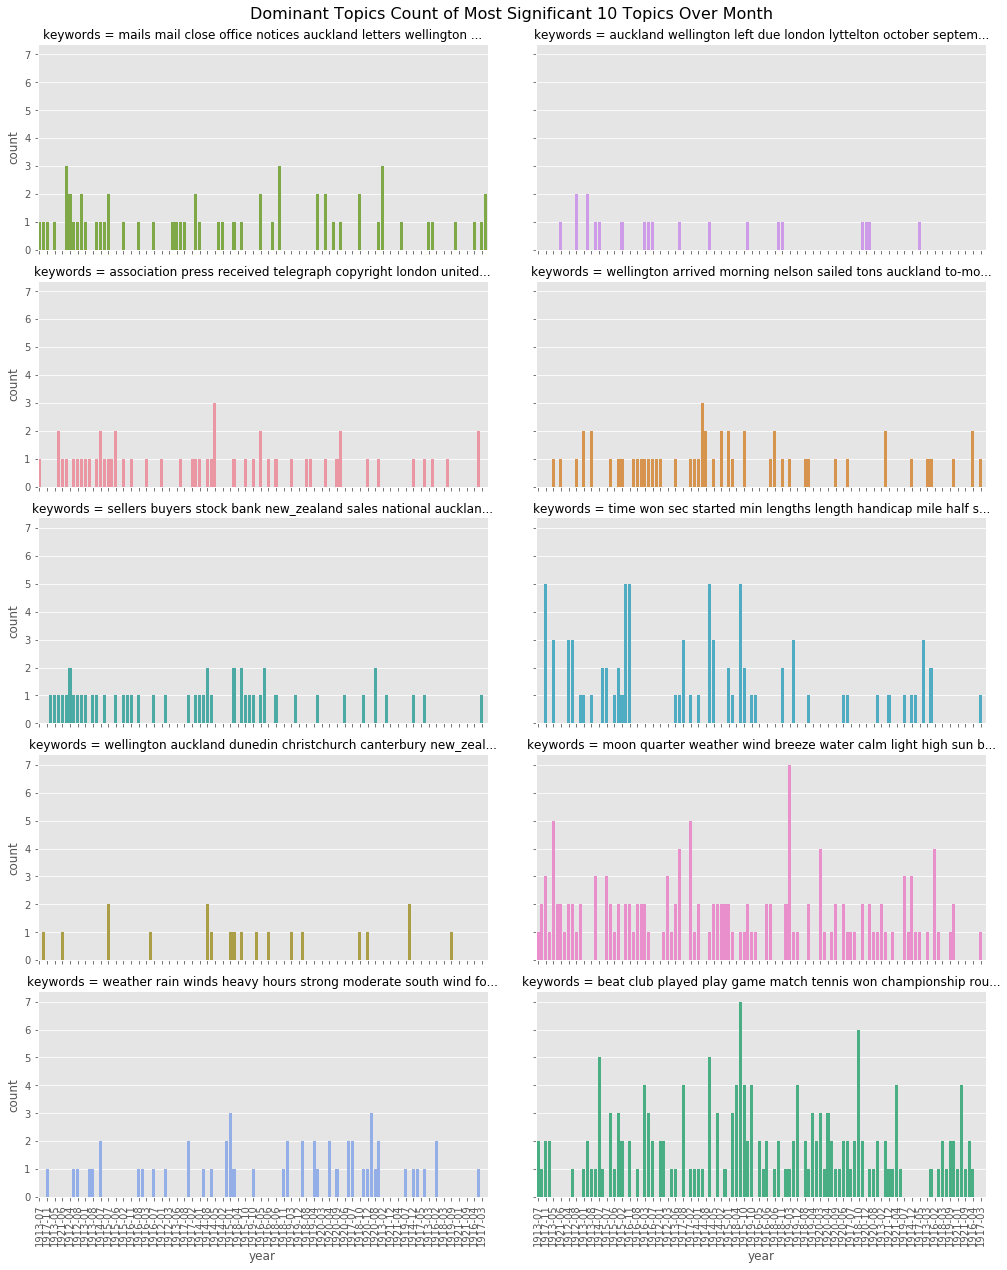

In [26]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

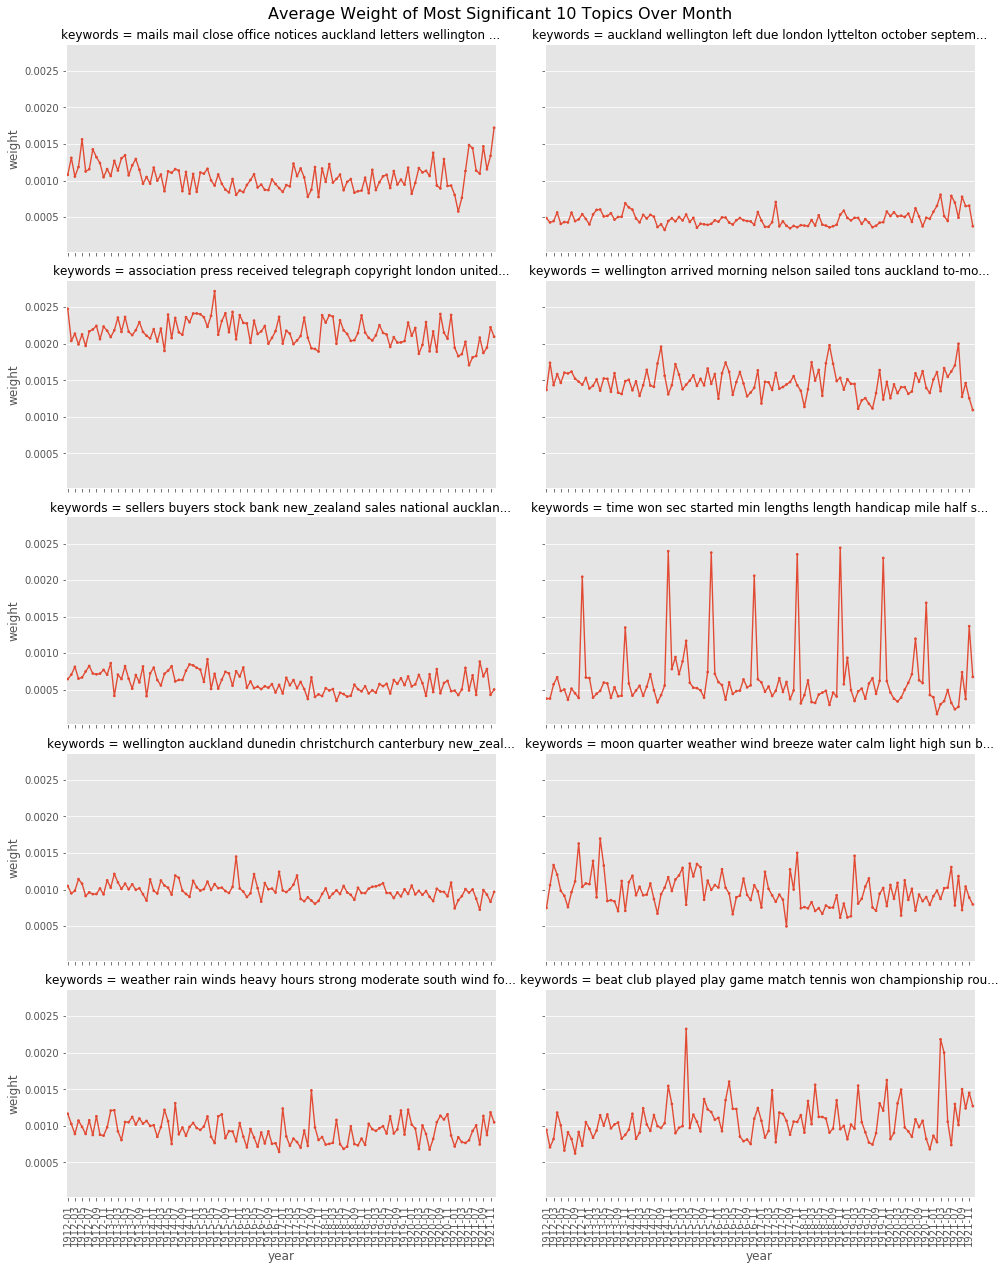

In [27]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Month',
            height=3.5,
            col_wrap=2)

---

In [28]:
gc.collect()

245